In [1]:
# Gross code to allow for importing from parent directory
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

### Imports

In [2]:
import torch
import einops
import pandas as pd
import numpy as np

from jaxtyping import Float
from torch import Tensor
import gc

from transformer_lens import HookedTransformer
from load_data import get_prompts_t
from plotting import ntensor_to_long
from jamesd_utils import reinforcement_ratio, projection_value

from plotly.graph_objs.layout._shape import Shape
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# Global settings and variables
torch.set_grad_enabled(False)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [3]:
prompts = get_prompts_t()
# prompts = get_prompts_t(n_text_prompts=160, n_code_prompts=40)

# Throws a warning if there is a non-unique prompt
if not (torch.unique(prompts, dim=0).shape == prompts.shape):
    print("WARNING: at least 1 prompt is not unique")

Loading 80 prompts from c4-tokenized-2b...


  0%|          | 0/80 [00:00<?, ?it/s]

Loading 20 prompts from code-tokenized...


  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
#Transformer Lens model names:
# https://github.com/neelnanda-io/TransformerLens/blob/3cd943628b5c415585c8ef100f65989f6adc7f75/transformer_lens/loading_from_pretrained.py#L127

model_name = "gelu-4l"
model = HookedTransformer.from_pretrained(model_name, device=device)
model.cfg.use_attn_result = True

Loaded pretrained model gelu-4l into HookedTransformer


In [5]:
# Define hook points to cache
hook_names = [
    "blocks.0.attn.hook_pattern",
    "blocks.0.attn.hook_v",
    "blocks.0.attn.hook_z",
    "blocks.0.attn.hook_result",
    "blocks.2.attn.hook_result",
]

# Run a forward pass and cache selected activations
_, cache = model.run_with_cache(
    prompts,
    # prompts[:30],
    names_filter=lambda name: name in hook_names,
    device=device,
)

# Delete logits and garbage collect
del _
gc.collect()
torch.cuda.empty_cache()

In [6]:
print(cache["blocks.0.attn.hook_pattern"].shape)  # (batch, head, posQ, posK)
print(cache["blocks.0.attn.hook_v"].shape)  # (batch, pos, head, d_head)
print(cache["blocks.0.attn.hook_z"].shape)  # (batch, pos, head, d_head)

torch.Size([100, 8, 1024, 1024])
torch.Size([100, 1024, 8, 64])
torch.Size([100, 1024, 8, 64])


In [7]:
# Double check calculation of `z` from `pattern` and `v` for H0.2
pattern_from_cache = cache["blocks.0.attn.hook_pattern"][:, 2, :, :]
v_from_cache = cache["blocks.0.attn.hook_v"][:, :, 2, :]
z_from_cache = cache["blocks.0.attn.hook_z"][:, :, 2, :]

z = einops.einsum(
    pattern_from_cache,  # (batch posQ posK)
    v_from_cache,  # (batch pos d_head)
    "batch posQ posK, batch posK d_head -> batch posQ d_head",
)
assert torch.allclose(z, z_from_cache, atol=1e-5)

# Double check calculation of `result` from `z` and `W_O` for H0.2
W_O_H0_2 = model.W_O[0, 2]  # (d_head, d_model)
result_from_cache = cache["blocks.0.attn.hook_result"][:, :, 2, :]  # (batch, pos, d_model)

result = einops.einsum(
    z_from_cache,
    W_O_H0_2,
    "batch pos d_head, d_head d_model -> batch pos d_model",
)
assert torch.allclose(result, result_from_cache, atol=1e-5)

### Decomposing BOS and non-BOS

In [8]:
# Slice BOS and non-BOS vectors for H0.2
pattern_bos = cache["blocks.0.attn.hook_pattern"][:, 2, :, 0:1]  # slice BOS but keep dim
pattern_nonbos = cache["blocks.0.attn.hook_pattern"][:, 2, :, 1:]
v_bos = cache["blocks.0.attn.hook_v"][:, 0:1, 2, :]
v_nonbos = cache["blocks.0.attn.hook_v"][:, 1:, 2, :]

print(pattern_bos.shape)
print(pattern_nonbos.shape)
print(v_bos.shape)
print(v_nonbos.shape)

torch.Size([100, 1024, 1])
torch.Size([100, 1024, 1023])
torch.Size([100, 1, 64])
torch.Size([100, 1023, 64])


In [9]:
# Calculate decomposed zs
z_bos = einops.einsum(
    pattern_bos,  # (batch posQ posK)
    v_bos,  # (batch pos d_head)
    "batch posQ posK, batch posK d_head -> batch posQ d_head",
)
z_nonbos = einops.einsum(
    pattern_nonbos,  # (batch posQ posK)
    v_nonbos,  # (batch pos d_head)
    "batch posQ posK, batch posK d_head -> batch posQ d_head",
)

# Calculate decomposed results from decomposed zs
result_bos = einops.einsum(
    z_bos,
    W_O_H0_2,
    "batch pos d_head, d_head d_model -> batch pos d_model",
)
result_nonbos = einops.einsum(
    z_nonbos,
    W_O_H0_2,
    "batch pos d_head, d_head d_model -> batch pos d_model",
)

# Validate decompositions
assert torch.allclose(z_bos + z_nonbos, z_from_cache, atol=1e-5)
assert torch.allclose(result_bos + result_nonbos, result_from_cache, atol=1e-5)

### Projecting H2.X onto H0.2_BOS and H0.2_nonBOS

In [10]:
# Get and rearrange vectors to project from and onto
result_H0_2_bos = einops.rearrange(result_bos, "batch pos d_model -> 1 batch pos d_model")
result_H0_2_nonbos = einops.rearrange(result_nonbos, "batch pos d_model -> 1 batch pos d_model")
results_H2_X = einops.rearrange(
    cache["blocks.2.attn.hook_result"], "batch pos head d_model -> head batch pos d_model"
)

# All shapes: (head, batch, pos, d_model)
print(result_H0_2_bos.shape)
print(result_H0_2_nonbos.shape)
print(results_H2_X.shape)

torch.Size([1, 100, 1024, 512])
torch.Size([1, 100, 1024, 512])
torch.Size([8, 100, 1024, 512])


In [11]:
# Create BOS dataframe with RRs and PVs
df_bos = ntensor_to_long(
    reinforcement_ratio(results_H2_X, result_H0_2_bos),
    value_name="reinforcement_ratio",
    dim_names=["L2_head", "batch", "pos"]
)
df_bos["projection_value"] = projection_value(results_H2_X, result_H0_2_bos).flatten().cpu().numpy()
df_bos["decomposition"] = "BOS-only"
df_bos["decomposition"] = df_bos["decomposition"].astype("category")
df_bos["L2_head"] = df_bos["L2_head"].astype("category")

# Create non-BOS dataframe with RRs and PVs
df_nonbos = ntensor_to_long(
    reinforcement_ratio(results_H2_X, result_H0_2_nonbos),
    value_name="reinforcement_ratio",
    dim_names=["L2_head", "batch", "pos"]
)
df_nonbos["projection_value"] = projection_value(results_H2_X, result_H0_2_nonbos).flatten().cpu().numpy()
df_nonbos["decomposition"] = "non-BOS"
df_nonbos["decomposition"] = df_nonbos["decomposition"].astype("category")
df_nonbos["L2_head"] = df_nonbos["L2_head"].astype("category")

# Concat BOS and non-BOS dataframes
df = pd.concat([df_bos, df_nonbos], ignore_index=True)

# Compute normalized RRs
df["rr_normalized"] = (
    df.groupby(["L2_head", "decomposition"])
        .transform(lambda x: (x - x.mean()) / x.std())
        ["reinforcement_ratio"]
)

In [12]:
# Check mean and std is 0.0 and 1.0
for head in range(model.cfg.n_heads):
    print(
        f"Head {head} yesBOS mean/std :",
        df.query(f"L2_head == {head} and decomposition == 'BOS-only'")["rr_normalized"].mean().round(2),
        df.query(f"L2_head == {head} and decomposition == 'BOS-only'")["rr_normalized"].std().round(2),
    )
    print(
        f"Head {head} nonBOS mean/std :",
        df.query(f"L2_head == {head} and decomposition == 'non-BOS'")["rr_normalized"].mean().round(2),
        df.query(f"L2_head == {head} and decomposition == 'non-BOS'")["rr_normalized"].std().round(2),
    )

Head 0 yesBOS mean/std : -0.0 1.0
Head 0 nonBOS mean/std : -0.0 1.0
Head 1 yesBOS mean/std : 0.0 1.0
Head 1 nonBOS mean/std : 0.0 1.0
Head 2 yesBOS mean/std : -0.0 1.0
Head 2 nonBOS mean/std : -0.0 1.0
Head 3 yesBOS mean/std : -0.0 1.0
Head 3 nonBOS mean/std : 0.0 1.0
Head 4 yesBOS mean/std : 0.0 1.0
Head 4 nonBOS mean/std : -0.0 1.0
Head 5 yesBOS mean/std : 0.0 1.0
Head 5 nonBOS mean/std : 0.0 1.0
Head 6 yesBOS mean/std : 0.0 1.0
Head 6 nonBOS mean/std : -0.0 1.0
Head 7 yesBOS mean/std : -0.0 1.0
Head 7 nonBOS mean/std : 0.0 1.0


In [13]:
# df memory usage in MB
df.memory_usage(deep=True).sum() / 1e6

153.190892

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638400 entries, 0 to 1638399
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   reinforcement_ratio  1637600 non-null  float32 
 1   L2_head              1638400 non-null  category
 2   batch                1638400 non-null  int64   
 3   pos                  1638400 non-null  int64   
 4   projection_value     1637600 non-null  float32 
 5   decomposition        1638400 non-null  object  
 6   rr_normalized        1637600 non-null  float32 
dtypes: category(1), float32(3), int64(2), object(1)
memory usage: 57.8+ MB


In [20]:
df_both = df.groupby(["L2_head", "batch", "pos"]).sum().reset_index()

df_both["rr_normalized"] = (
    df_both.groupby(["L2_head"])
        .transform(lambda x: (x - x.mean()) / x.std())
        ["reinforcement_ratio"]
)

/tmp/ipykernel_274215/2009169315.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_both = df.groupby(["L2_head", "batch", "pos"]).sum().reset_index()


### Plots

/tmp/ipykernel_274215/3395121105.py:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=filtered_df.groupby(["batch", "pos"]).sum().reset_index(),  # sum over heads


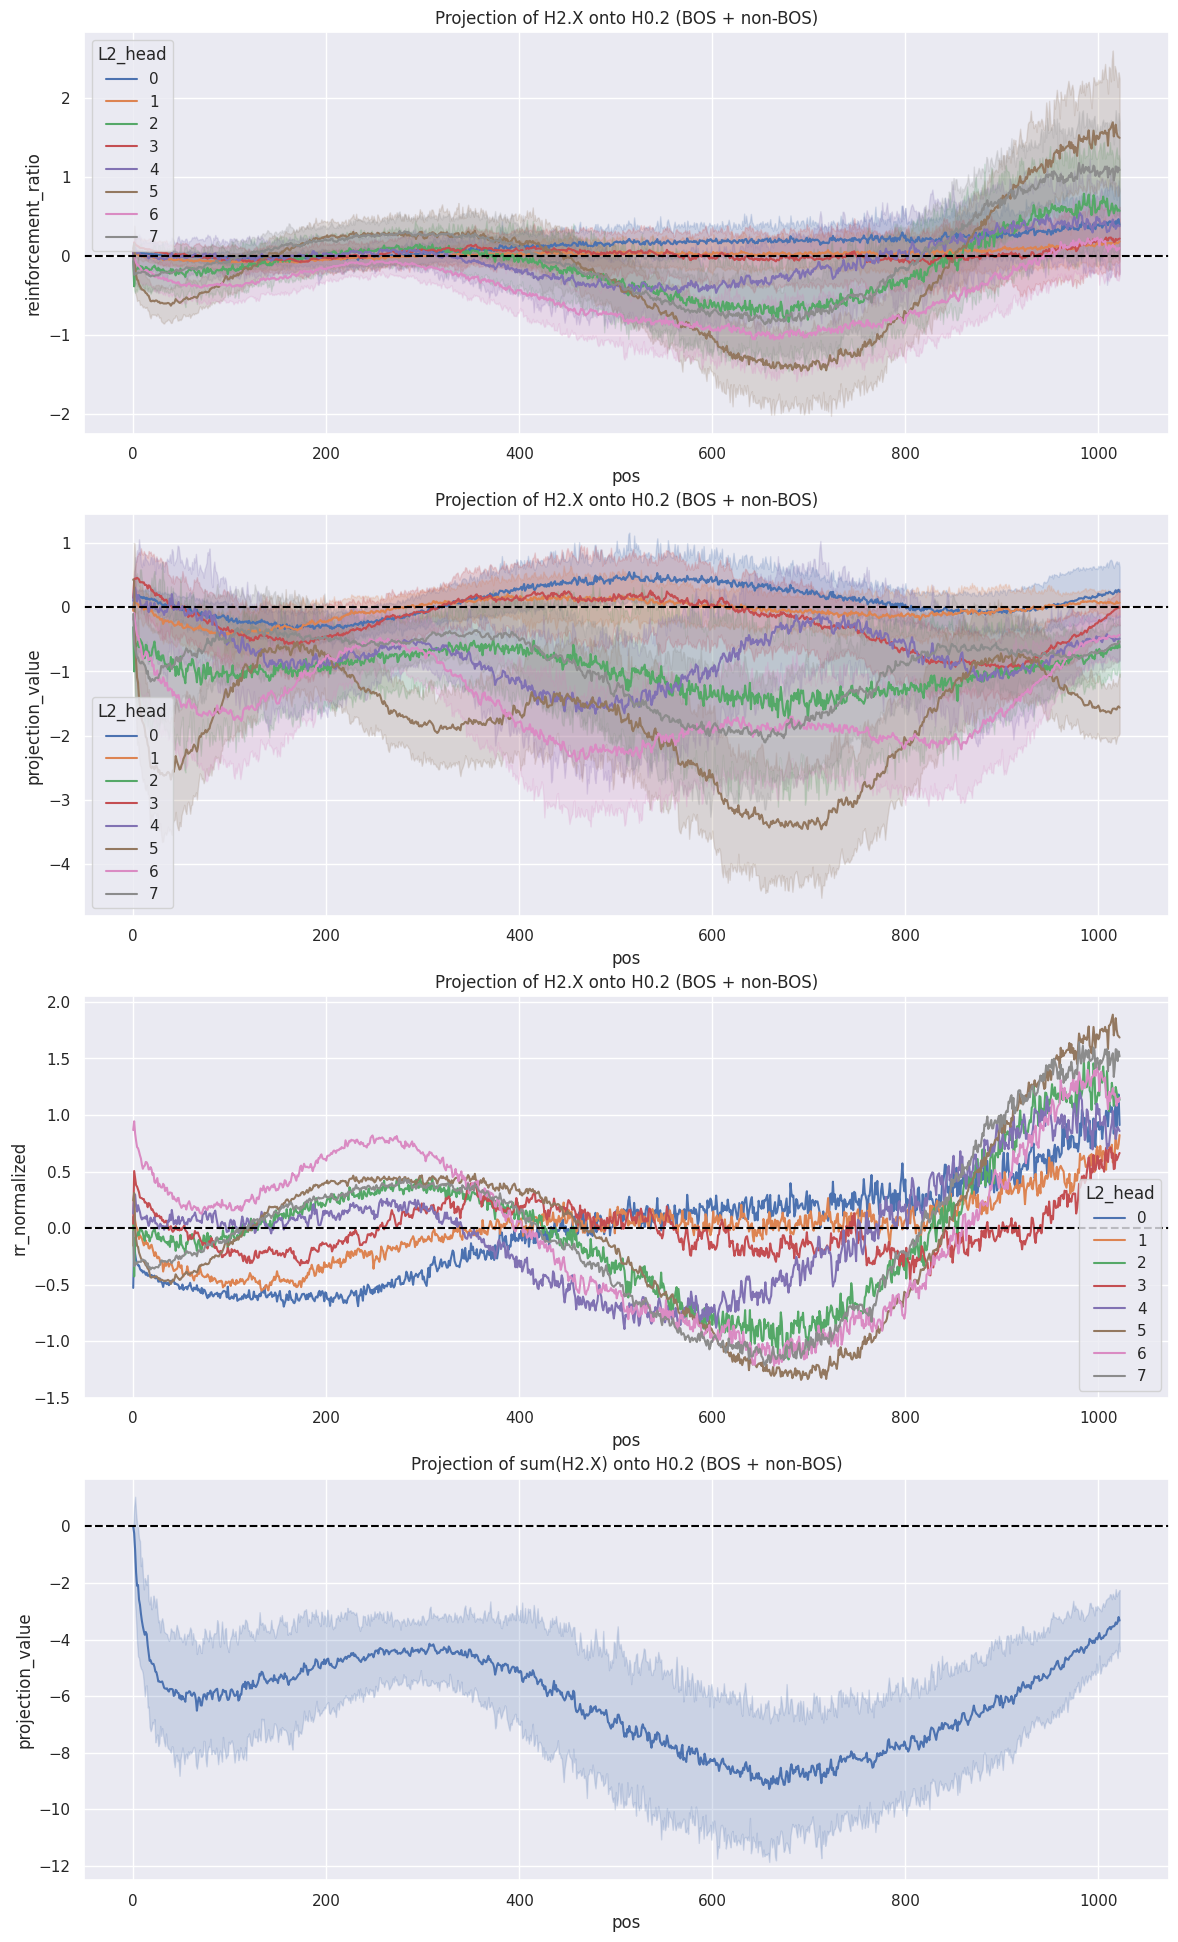

In [37]:
fig, ax = plt.subplots(4, 1, figsize=(14, 4*6))

# Filter dataframe to plot
decomposition = "BOS + non-BOS"
heads_to_include = [0,1,2,3,4,5,6,7]
# heads_to_include = [2,4,5,6,7]

filtered_df = (
    df_both
        .query("L2_head in @heads_to_include")
        .query(f"pos <= 1022")  # NOTE: something janky happens at pos=1023
)

# Subplot 1
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="reinforcement_ratio",
    hue="L2_head",
    errorbar=("pi", 75),
    ax=ax[0],
)
ax[0].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 2
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="projection_value",
    hue="L2_head",
    errorbar=("pi", 75),
    ax=ax[1],
)
ax[1].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 3
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="rr_normalized",
    hue="L2_head",
    errorbar=None,
    ax=ax[2],
)
ax[2].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 4
sns.lineplot(
    data=filtered_df.groupby(["batch", "pos"]).sum().reset_index(),  # sum over heads
    x="pos",
    y="projection_value",
    errorbar=("pi", 75),
    ax=ax[3],
)
ax[3].set_title(f"Projection of sum(H2.X) onto H0.2 ({decomposition})")

# Add zero hlines
for i in range(4):
    ax[i].axhline(0, color="black", linestyle="--")

/tmp/ipykernel_274215/3054165849.py:48: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=filtered_df.groupby(["batch", "pos"]).sum().reset_index(),  # sum over heads


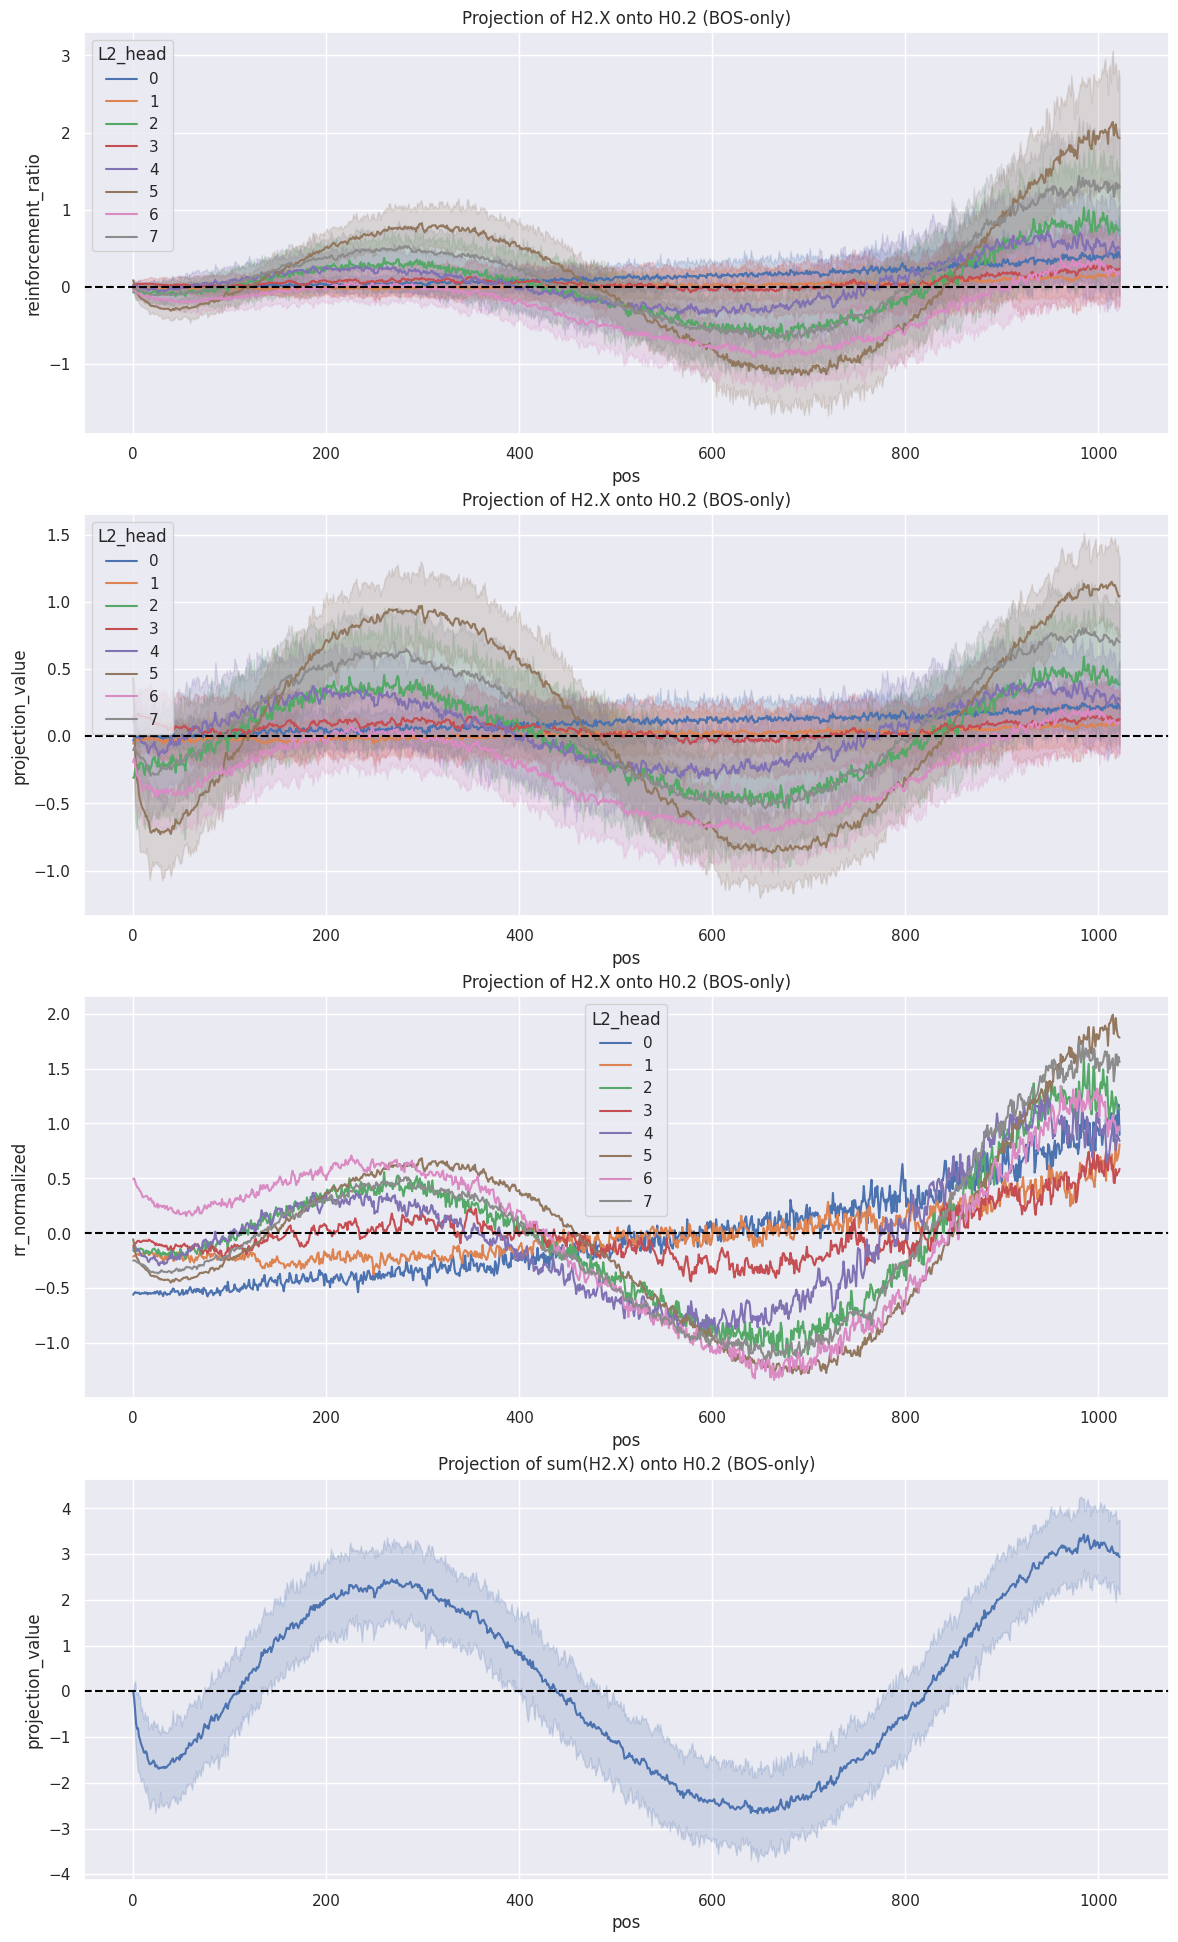

In [35]:
fig, ax = plt.subplots(4, 1, figsize=(14, 4*6))

# Filter dataframe to plot
decomposition = "BOS-only"
heads_to_include = [0,1,2,3,4,5,6,7]
# heads_to_include = [2,4,5,6,7]

filtered_df = (
    df.query("L2_head in @heads_to_include")
      .query(f"decomposition == '{decomposition}' & pos <= 1022")  # NOTE: something janky happens at pos=1023
)

# Subplot 1
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="reinforcement_ratio",
    hue="L2_head",
    errorbar=("pi", 75),
    ax=ax[0],
)
ax[0].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 2
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="projection_value",
    hue="L2_head",
    errorbar=("pi", 75),
    ax=ax[1],
)
ax[1].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 3
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="rr_normalized",
    hue="L2_head",
    errorbar=None,
    ax=ax[2],
)
ax[2].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 4
sns.lineplot(
    data=filtered_df.groupby(["batch", "pos"]).sum().reset_index(),  # sum over heads
    x="pos",
    y="projection_value",
    errorbar=("pi", 75),
    ax=ax[3],
)
ax[3].set_title(f"Projection of sum(H2.X) onto H0.2 ({decomposition})")

# Add zero hlines
for i in range(4):
    ax[i].axhline(0, color="black", linestyle="--")

/tmp/ipykernel_274215/734316151.py:48: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=filtered_df.groupby(["batch", "pos"]).sum().reset_index(),  # sum over heads


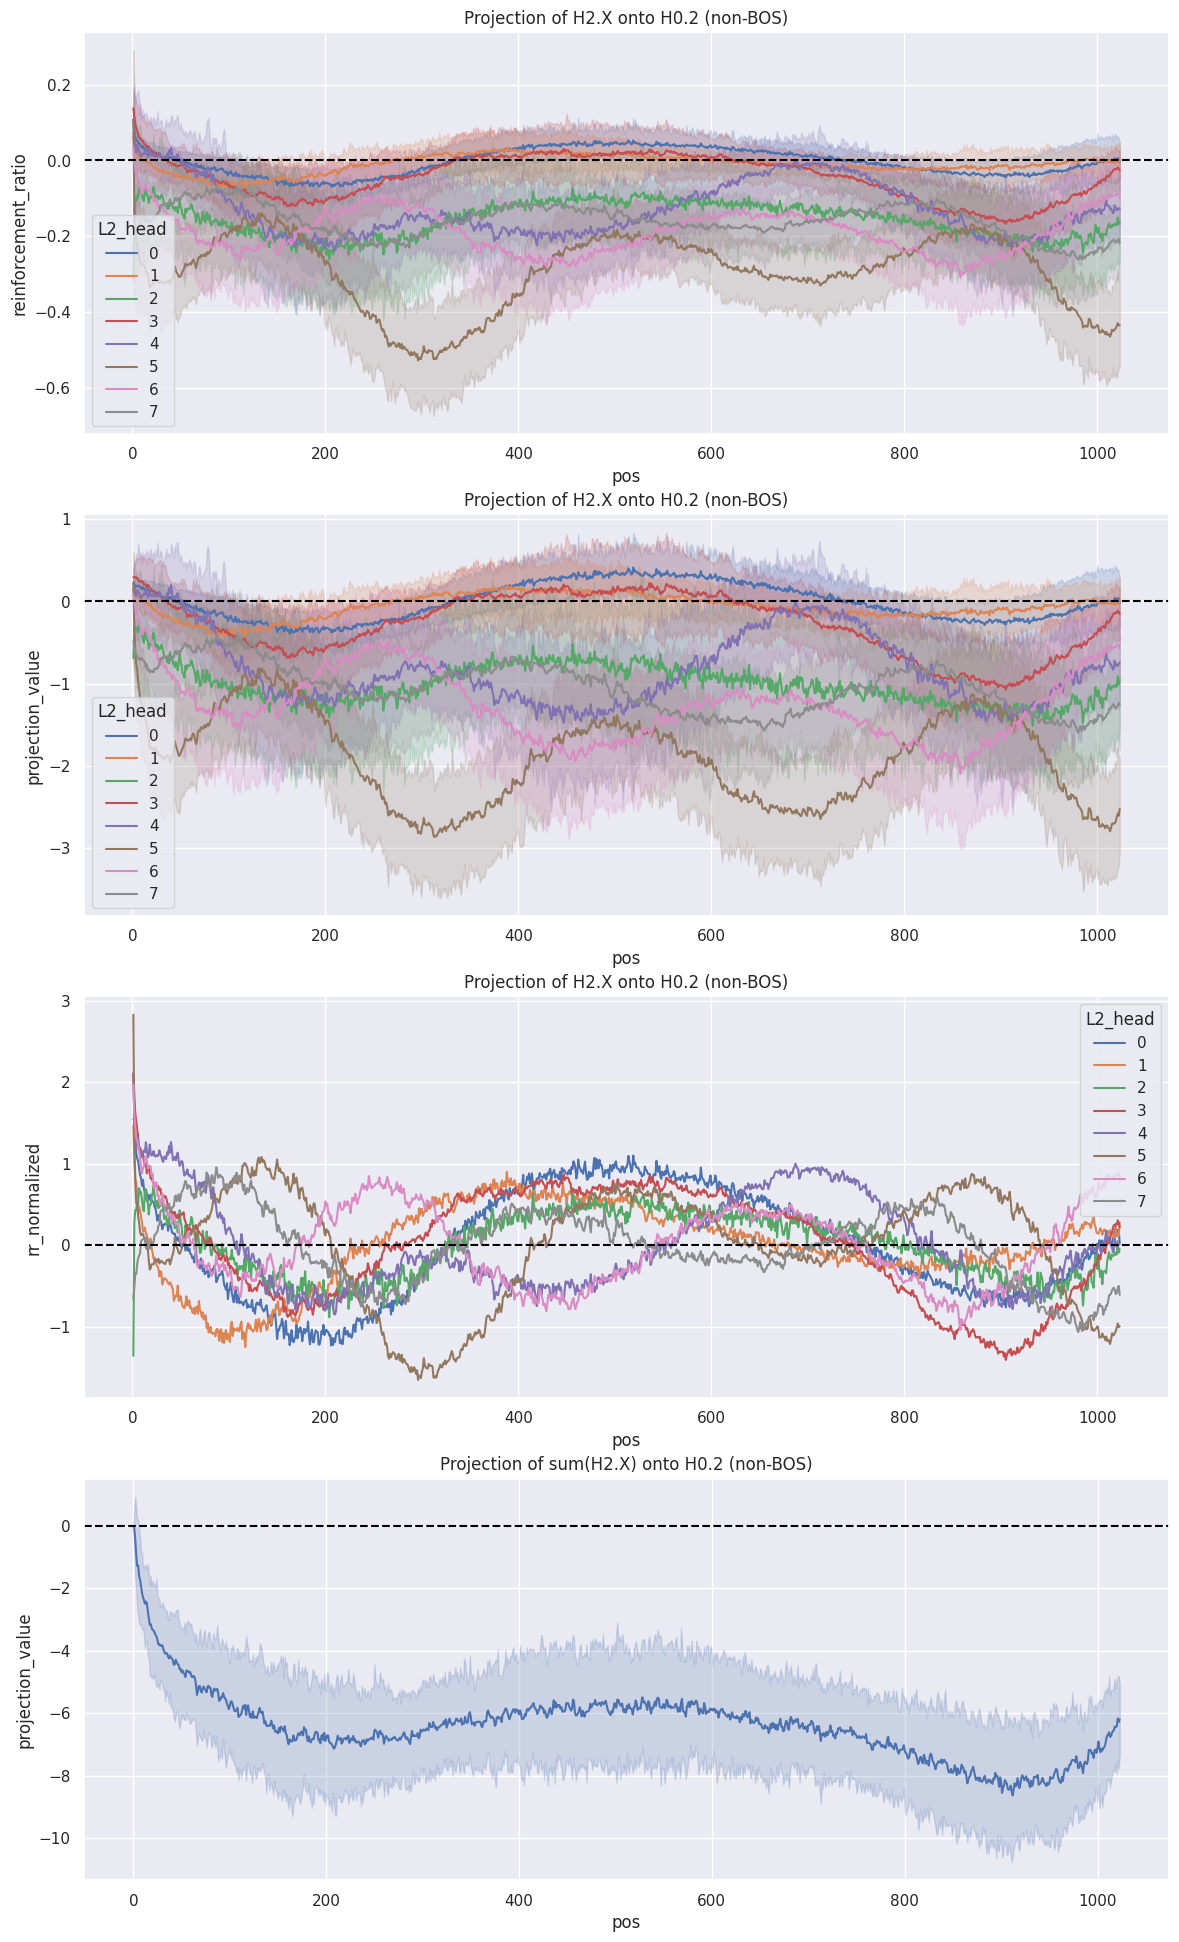

In [36]:
fig, ax = plt.subplots(4, 1, figsize=(14, 4*6))

# Filter dataframe to plot
decomposition = "non-BOS"
heads_to_include = [0,1,2,3,4,5,6,7]
# heads_to_include = [2,4,5,6,7]

filtered_df = (
    df.query("L2_head in @heads_to_include")
      .query(f"decomposition == '{decomposition}'")
)

# Subplot 1
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="reinforcement_ratio",
    hue="L2_head",
    errorbar=("pi", 75),
    ax=ax[0],
)
ax[0].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 2
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="projection_value",
    hue="L2_head",
    errorbar=("pi", 75),
    ax=ax[1],
)
ax[1].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 3
sns.lineplot(
    data=filtered_df,
    x="pos",
    y="rr_normalized",
    hue="L2_head",
    errorbar=None,
    ax=ax[2],
)
ax[2].set_title(f"Projection of H2.X onto H0.2 ({decomposition})")

# Subplot 4
sns.lineplot(
    data=filtered_df.groupby(["batch", "pos"]).sum().reset_index(),  # sum over heads
    x="pos",
    y="projection_value",
    errorbar=("pi", 75),
    ax=ax[3],
)
ax[3].set_title(f"Projection of sum(H2.X) onto H0.2 ({decomposition})")

# Add zero hlines
for i in range(4):
    ax[i].axhline(0, color="black", linestyle="--")